# **ADSP - P8 PROJECT** - scientific papers classifier based on NLP
---
**CANDIDATES**

GILLIO FRANCESCO

SEMINARIO YRIGOYEN CESAR AUGUSTO

**COURSE** Applied Data Science Project

**University** Politecnico di Torino - Italy


## Project description

**BertTopic** is used to create a semi-supervised model with labels available

**Dataset for testing** can be downloaded fro hugginface at the link: [dhiruHF papers multilabeled](https://huggingface.co/datasets/dhiruHF/research_paper_multi_label_data_balanced)

**Dataset for the project** is contained in the input_data folder, called: articles_2023.csv

 ## <span style="font-family:Verdana; color:blue">  0. TO DO

<span style="font-family:Verdana; color:blue">

- download similar dataset from hugging-face to start - DONE
- data cleaning - DONE
- create embeddings - DONE
- export embeddings - DONE
- start with the model - IN PROGRESS
***

## 1. Exploring the dataset

In [1]:
%%capture
#!pip install bertopic
!pip install datasets
#!pip install openai
import tqdm as notebook_tqdm
from tqdm.autonotebook import tqdm, trange

import pandas as pd
import numpy as np
import time as Time

### 1.1 Exploring similar dataset




In [ ]:
from datasets import load_dataset

dataset = load_dataset("dhiruHF/research_paper_multi_label_data_balanced")
terms_number= len(dataset['train'])
print(f"N° wiki terms: {terms_number}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/382 [00:00<?, ?B/s]

(…)-00000-of-00001-6cb8c751614cff33.parquet:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1985 [00:00<?, ? examples/s]

N° wiki terms: 1985


In [ ]:
def get_chapters(text):
    chapters = text.split('###')[2]
    labels = text.split('###')[3]
    labels = labels.split(':')[1]
    title=chapters.split('\n')[2].split(':')[1]
    abstract=chapters.split('\n')[3:]
    abstract[0]=abstract[0][9:]
    delimiter="\n"
    abstract=delimiter.join(abstract)
    #labels=labels.split(',')
    #labels=[label.strip() for label in labels]
    item_dict={}
    item_dict['title']=title
    item_dict['abstract']=abstract
    item_dict['labels']=labels
    return item_dict


In [ ]:
item=get_chapters(dataset['train'][0]['text'])
print(item['title'])

 Reconstructing Subject-Specific Effect Maps


In [ ]:
dataset['train'][0]['text'].split('###')[2]

"RESEARCH PAPER:\n\nTitle: Reconstructing Subject-Specific Effect Maps\nAbstract:   Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrap

In [ ]:
#converting in structure dict:{title,abstract,labels}
data_dict=[get_chapters(item) for item in dataset['train']['text']]

In [ ]:
item=1345
print(f"title:\n {data_dict[item]['title']}")
print(f"abstract:\n {data_dict[item]['abstract']}")
print(f"labels:\n {data_dict[item]['labels']}")

title:
  Bounds on the expected size of the maximum agreement subtree for a given tree shape
abstract:
    We show that the expected size of the maximum agreement subtree of two
$n$-leaf trees, uniformly random among all trees with the shape, is
$\Theta(\sqrt{n})$. To derive the lower bound, we prove a global structural
result on a decomposition of rooted binary trees into subgroups of leaves
called blobs. To obtain the upper bound, we generalize a first moment argument
for random tree distributions that are exchangeable and not necessarily
sampling consistent.



labels:
  ['Quantitative Biology']


<Axes: xlabel='labels'>

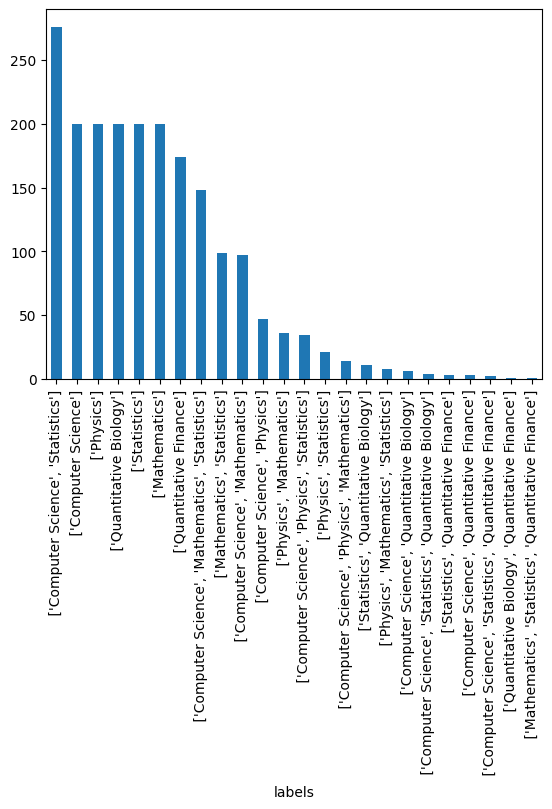

In [ ]:
data_df= pd.DataFrame(data_dict)
data_df['labels'].value_counts().plot(kind='bar')

### 1.2 Exploring article_2023 dataset

In [3]:
!git clone https://github.com/Cesar85Hol/papers-class-NLP.git

Cloning into 'papers-class-NLP'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 10.64 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [4]:
data_df=pd.read_csv('/content/papers-class-NLP/input_data/articles_2023.csv')
titles=data_df['Title'].to_list()
abstracts=data_df['Abstract'].to_list()
labels=data_df['Label'].to_list()

<Axes: xlabel='Label'>

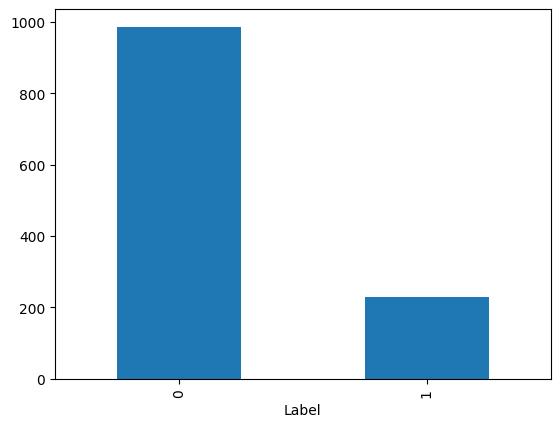

In [ ]:
data_df['Label'].value_counts().plot(kind='bar')

In [ ]:
print(abstracts[0])

PURPOSE: The transition towards adult-focused healthcare comprises a complex process requiring careful, individualized guidance of adolescents with congenital heart disease (CHD). Detailed data on their preferences regarding disease-related information and acquirable transitional skills are mostly lacking. We examined the preferences of CHD adolescents in the early transition stage. METHODS: A cross-sectional descriptive study was performed with adolescents recruited from a transition program. Two questionnaires assessing needs for information and transitional skills were used. Only questionnaires completed in the early transition stage were included. RESULTS: Forty-nine adolescents participated (mean age 15.9 ± 1.2 years, 43% girls). 59% requested information about their heart and previous and/or future surgeries/interventions, 45% about sports and medication, and a maximum of 27% about psychosocial topics. More girls than boys requested surgical information (76% versus 46%; p = 0.04)

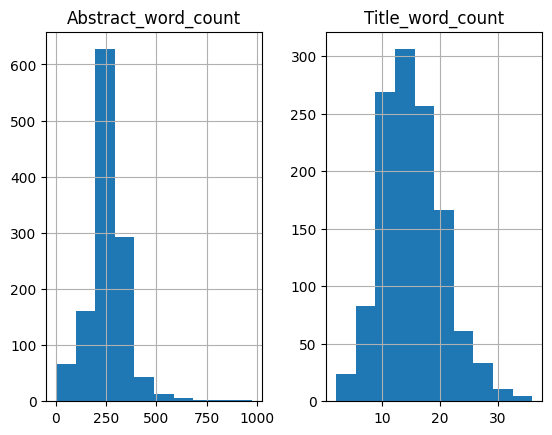

In [5]:
#counting words in each abstract to manage embeddings
#splitting by string:
import matplotlib.pyplot as plt
data_df['Abstract_word_count'] = data_df['Abstract'].apply(lambda x: len(str(x).split()))
data_df['Title_word_count'] = data_df['Title'].apply(lambda x: len(str(x).split()))

#ax=data_df['Abstract_word_count'].hist(bins=20)
ax=data_df[['Abstract_word_count','Title_word_count']].hist(bins=10)
#data_df[['Abstract_word_count','Title_word_count']].plot(kind='hist',alpha=0.7,bins=10)
#plt.xlabel('Word Count')
#plt.ylabel('Frequency')
#plt.title('Word Count Distribution')
#ax.set_xlabel('Word Count')
#ax.set_ylabel('Frequency')
#ax.set_title('Word Count Distribution')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Text(0.5, 1.0, 'Word Count Distribution - NLTK')

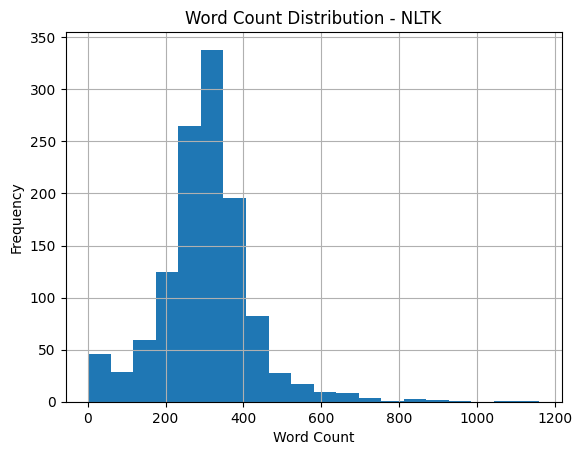

In [ ]:
#nltk:
#it holds punctuation, incase we don't want it use
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
words=[len(word_tokenize(str(text))) for text in data_df['Abstract']]
data_df['Abstract_word_count_nltk']=words

ax=data_df['Abstract_word_count_nltk'].hist(bins=20)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Word Count Distribution - NLTK')

## 2. Preparing the dataset for embeddings

### 2.1 Cleaning dataset

In [6]:
# functions preparing the dataset for BERTopic architecture

#1. Removing duplicates
print(f"initial size: {data_df.shape}")
data_df_clean=data_df.drop_duplicates(subset=['Title'], keep ='first')
print(f"new size of items after removing duplicates: {data_df_clean.shape}")


initial size: (1215, 19)
new size of items after removing duplicates: (1214, 19)


In [7]:
#2. Managing nan or empty sections
tot_nan=data_df_clean['Title'].isnull().sum()
print(f"total nan Titles in dataset: {tot_nan}")
tot_nan=data_df_clean['Abstract'].isnull().sum()
print(f"total nan abstracts in dataset: {tot_nan}")

#saving titles without abstract --> find abstracts and complete dataset
#titles_nanAbs=data_df_clean[data_df_clean['Abstract'].isnull()]['Title']#.to_list()
#titles_nanAbs.to_excel('titles_nanAbs.xlsx')
#print(f"titles with nan in abstract: {titles_nanAbs}")

#Manage nan _hyp1: if both title and abstract nan -> delete; if just 1 nan, keep item and put an empty string (to allow tokenization)
for elem in data_df_clean.index:
    if pd.isnull(data_df_clean.at[elem, 'Title']) and pd.isnull(data_df_clean.at[elem, 'Abstract']):
        data_df_clean.drop(elem, inplace=True)
    elif pd.isnull(data_df_clean.at[elem, 'Title']):
        data_df_clean.at[elem, 'Title'] = ''
    elif pd.isnull(data_df_clean.at[elem, 'Abstract']):
        data_df_clean.at[elem, 'Abstract'] = ''


tot_nan=data_df_clean['Title'].isnull().sum()
print(f"total nan Titles in dataset after manage: {tot_nan}")
tot_nan=data_df_clean['Abstract'].isnull().sum()
print(f"total nan abstracts in dataset after manage: {tot_nan}")


total nan Titles in dataset: 0
total nan abstracts in dataset: 44
total nan Titles in dataset after manage: 0
total nan abstracts in dataset after manage: 0


### 2.2 Managing titles & abstracts

<ipython-input-9-43bdd96b3f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_clean['Title_Abstract']=data_df_clean['Title'].astype(str)+' ' +data_df_clean['Abstract'].astype(str)
<ipython-input-9-43bdd96b3f14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_clean['Title_Abstract_word_count'] = data_df_clean['Title_Abstract'].apply(lambda x: len(x.split()))


avg words in Title_Abstract: 271.7174629324547


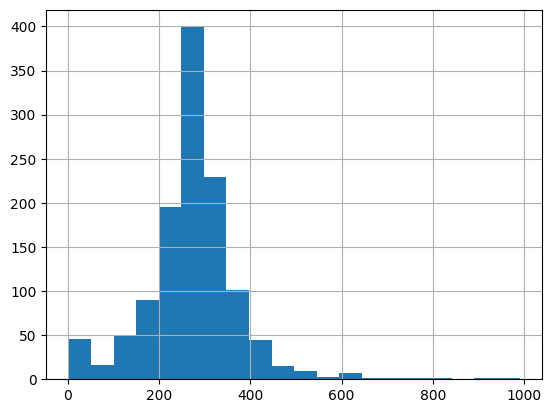

In [9]:
# concatenating title + abstract at text level --> case 1: textjoined
data_df_clean['Title_Abstract']=data_df_clean['Title'].astype(str)+' ' +data_df_clean['Abstract'].astype(str)
data_df_clean['Title_Abstract_word_count'] = data_df_clean['Title_Abstract'].apply(lambda x: len(x.split()))
data_df_clean['Title_Abstract_word_count'].hist(bins=20)
print(f"avg words in Title_Abstract: {data_df_clean['Title_Abstract_word_count'].mean()}")



## 3. Embeddings calculation

### 3.1 Precalculate embeddings (if loading pass to 3.2)


In [14]:
#FUNCTIONS TO JOIN FEATURES OF TITLE & ABSTRACT
from sklearn.preprocessing import MinMaxScaler

def sum_Embedds(feat1,feat2,mode=0):
  '''
  mode:0 -> no minmax scaler, data is just added
  mode:1 -> minmax scaler applied to each feature
  '''
  if(mode==0):
    combined_features=feat1+feat2
  else:
    scaler = MinMaxScaler()
    feat1_norm = scaler.fit_transform(feat1.reshape(-1, 1)).flatten()
    feat2_norm = scaler.fit_transform(feat2.reshape(-1, 1)).flatten()
      # Somma
    combined_features = feat1_norm + feat2_norm

  return combined_features

In [ ]:
#previous
'''
embedding_model_ = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
title_embeddings = embedding_model.encode(data_df_clean['Title'].tolist(), show_progress_bar=True)
abstract_embeddings = embedding_model.encode(data_df_clean['Abstract'].tolist(), show_progress_bar=True)
# saving data
#import numpy as np
np.save('title_embeddings_all-MiniLM-L6-v2.npy', title_embeddings)
np.save('abstract_embeddings_all-MiniLM-L6-v2.npy', abstract_embeddings)
data_df_clean.to_pickle('data_df_clean.pkl')
embeddings = embedding_model.encode(data_df_clean['Title_Abstract'].tolist(), show_progress_bar=True)
'''

In [ ]:
from sentence_transformers import SentenceTransformer
# Pre-calculate embeddings
# _1: all-MiniLM-L6-v2
# _2: all-mpnet-base-v2
# _3: longformer
# _4: neuml/pubmedbert-base-embeddings
df_embeddings=data_df_clean[['Title','Abstract','Label']]
models=['sentence-transformers/all-MiniLM-L6-v2','sentence-transformers/all-mpnet-base-v2','neuml/pubmedbert-base-embeddings']

for model in models:
  print(f"model: {model}")
  embedding_model = SentenceTransformer(model)
  start=Time.time()
  embeddings = embedding_model.encode(data_df_clean['Title_Abstract'].tolist(), show_progress_bar=True)
  end=Time.time()
  print(f"embedding duration: {end-start}")
  df_embeddings[f"{model.split('/')[1]}_textjoined"]=list(embeddings)
  title_embeddings = embedding_model.encode(data_df_clean['Title'].tolist(), show_progress_bar=True)
  abstract_embeddings = embedding_model.encode(data_df_clean['Abstract'].tolist(), show_progress_bar=True)
  embeddings=sum_Embedds(title_embeddings,abstract_embeddings)
  df_embeddings[f"{model.split('/')[1]}_sumfeats"]=list(embeddings)



In [33]:
df_embeddings.to_pickle('df_embeddings.pkl')

### 3.2 Uploading embeddings

In [21]:
# first load the files to the drive folder following this process
#UNCOMMENT BELOW TO LOAD

#!git clone https://github.com/Cesar85Hol/papers-class-NLP.git
#title_embeddings=np.load('/content/papers-class-NLP/embeddings/title_embeddings_all-MiniLM-L6-v2.npy')
#abstract_embeddings=np.load('/content/papers-class-NLP/embeddings/abstract_embeddings_all-MiniLM-L6-v2.npy')
data_df=pd.read_pickle('/content/papers-class-NLP/embeddings/data_df_clean_P8.pkl')
df_embeddings=pd.read_pickle('/content/papers-class-NLP/embeddings/df_embeddings.pkl')


In [38]:
print(f"avg words in abstracts: {data_df['Abstract_word_count'].mean()}")
print(f"avg words in titles: {data_df['Title_word_count'].mean()}")

avg words in abstracts: 256.5971993410214
avg words in titles: 15.156507413509061


## 4 MLP CLASSIFICATOR

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
from tkinter.constants import X
import time as Time
y=df_embeddings['Label']
#split in train - val - test : 60% - 20% - 20%
#X_train,X_t,y_train,y_t=train_test_split(embeddings,y,test_size=0.4,random_state=42)
#X_val,X_test,y_val,y_test=train_test_split(X_t,y_t,test_size=0.5,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(df_embeddings,y,test_size=0.2,random_state=42)

for embedd in df_embeddings.columns[3:]:
  print(f"model: {embedd}")
  start=Time.time()
  mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
  mlp_model.fit(X_train[embedd].to_list(), y_train)
  y_pred = mlp_model.predict(X_val[embedd].to_list())
  accuracy = accuracy_score(y_val, y_pred)
  end=Time.time()
  print("{embedd} model Accuracy:", accuracy)
  print(f"classification duration: {end-start}")

model: all-MiniLM-L6-v2_textjoined
{embedd} model Accuracy: 0.9506172839506173
classification duration: 1.4921369552612305
model: all-MiniLM-L6-v2_sumfeats
{embedd} model Accuracy: 0.9670781893004116
classification duration: 1.0357341766357422
model: all-mpnet-base-v2_textjoined
{embedd} model Accuracy: 0.9753086419753086
classification duration: 1.8382654190063477
model: all-mpnet-base-v2_sumfeats
{embedd} model Accuracy: 0.9670781893004116
classification duration: 1.7331674098968506
model: pubmedbert-base-embeddings_textjoined
{embedd} model Accuracy: 0.9670781893004116
classification duration: 1.092881679534912
model: pubmedbert-base-embeddings_sumfeats
{embedd} model Accuracy: 0.9588477366255144
classification duration: 1.2591960430145264


### 4.1 Training

In [28]:
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

### 4.2 Testing

In [29]:
y_pred = mlp_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9588477366255144


### 4.3 Saving model

In [ ]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("./model_dir/hdbscan", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

## 4. Accuracy & other parameters

In [30]:
X_train_tot=np.concatenate((X_train,X_val))
y_train_tot=np.concatenate((y_train,y_val))
mlp_modelfin = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_modelfin.fit(X_train_tot, y_train_tot)

y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9423868312757202


### Creating plots

In [ ]:
%matplotlib inline


### Model visualization: topics and documents

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# Documents
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
labels=md_terms_ss_df['medical_term'].to_list()
topic_model.visualize_documents(labels, reduced_embeddings=reduced_embeddings)